# Question 1

Implementation of k-nearest neighbours and cross validation from scratch to better understand the algorithms. Each input x is classified according to the most frequent class amongst its k nearest neighbours as measured by the Euclidean distance (L2-norm).

In [0]:
import numpy as np
from scipy import stats

class NearestNeighbors:
  
  def __init__(self, n_neighbors=5):
    self.n_neighbors = n_neighbors
    self.X = []
    self.y = []

  def fit(self, X, y):
    self.X = X
    self.y = y

  def kneighbors(self, X):
    np_X = np.array(X)
    np_space = np.array(self.X)
    ret = []
    for i in range(np_X.shape[0]):
      dist = np.linalg.norm(np_space - np_X[i], axis=1)
      idx = np.argpartition(dist, self.n_neighbors)
      ret.append(list(idx[:self.n_neighbors]))
    return ret
  
  def predict(self, X):
    classifications = []
    set_neighbors = self.kneighbors(X)
    for i in range(len(set_neighbors)):
      neighbor_labels = []
      for index in set_neighbors[i]:
        neighbor_labels.append(self.y[index])
      # find most common classification of neighbor indeces
      classification = stats.mode(neighbor_labels)
      classifications.append(classification[0][0])
    return classifications
  
  def model_accuracy(self, X, y):
      classifications = self.predict(X)
      correct = 0
      for i in range(len(classifications)):
        if classifications[i] == y[i]:
          correct += 1
      model_accuracy = correct / len(y)
      return model_accuracy

The dataset being used is a modified version of the Optical Recognition of Handwritten Digits Dataset from the UCI repository. It contains pre-processed black and white images of the digits 5 and 6. Each attribute indicates how many pixels are black in a patch of 4 x 4 pixels.

Format: there is one row per image and one column per attribute. The class labels are 5 and 6. The training set is already divided into 10 subsets for 10-fold cross validation.

In [0]:
import pandas as pd
import itertools

github_url = 'https://raw.githubusercontent.com/RohanK99/machine-learning/master/knn-dataset/'

# read test data
def read_test_data():  
  data_url = github_url + 'testData.csv'
  label_url = github_url + 'testLabels.csv'
  data = pd.read_csv(data_url, header=None)
  test_data = data.values.tolist()
  labels = pd.read_csv(label_url, header=None)
  test_labels = labels.values.tolist()
  return test_data, list(itertools.chain.from_iterable(test_labels))

# read training data
def read_training_data():
  training_data = []
  training_labels = []
  for i in range(10):
    url = github_url + 'trainData{}.csv'.format(i+1)
    data = pd.read_csv(url, header=None)
    training_data.append(data.values.tolist())
    url = github_url + 'trainLabels{}.csv'.format(i+1)
    data = pd.read_csv(url, header=None)
    training_labels.append(data.values.tolist())
  return training_data, training_labels

# X must be already be split into cv parts
def knn_cross_validation(X, y, cv=10):
  accuracy = [0]*int((len(list(itertools.chain.from_iterable(X)))*((cv-1)/cv)))
  for i in range(0, len(X)):
    validation_set = X[i]
    validation_labels = list(itertools.chain.from_iterable(y[i]))
    training_set = list(itertools.chain.from_iterable(X[:i] + X[i+1:]))
    training_labels = list(itertools.chain.from_iterable( \
                        list(itertools.chain.from_iterable(y[:i] + y[i+1:]))))
    for k in range(1, len(training_set)): # try all K up till training_set size
      correct = 0 # number of correct classifications
      n = NearestNeighbors(n_neighbors=k) # k nearest neighbors 
      n.fit(training_set, training_labels) # train KNN with training set
      classifications = n.predict(validation_set) # predict validaton set
      for index in range(len(classifications)):
        # if validation set was predicted correctly increment counter
        if classifications[index] == validation_labels[index]:
          correct += 1
      # calculate average accuracy for all k-fold trials
      accuracy[k] = (accuracy[k] * i + (correct / len(validation_labels)))/(i+1)
  return range(len(training_set)), accuracy

The driver script runs 10 cross validation finding an optimal k. This parameter k is used for KNN prediction and finds the model accuracy relative to a test set. The k value might be skewed because for classification ties it is classified as the smaller of the 2 numbers. For a more optimal solution a weighted KNN should be used.

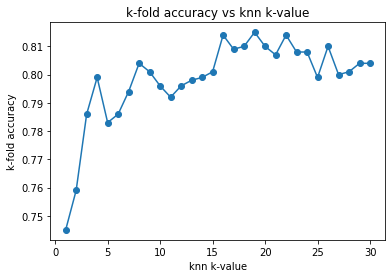

Optimal k: 19
Model Accuracy: 0.7272727272727273


In [19]:
import matplotlib.pyplot as plt

training_data, training_labels = read_training_data()
x, y = knn_cross_validation(training_data, training_labels)
plt.plot(x[1:31], y[1:31], '-o') # peak can be found in first 30 values
plt.title('k-fold accuracy vs knn k-value')
plt.ylabel('k-fold accuracy')
plt.xlabel('knn k-value')
plt.show()

# format training_data for model_accuracy
training_data = list(itertools.chain.from_iterable(training_data))
training_labels = list(itertools.chain.from_iterable( \
                    list(itertools.chain.from_iterable(training_labels))))
test_data, test_labels = read_test_data()

k = y.index(max(y)) # optimal k
print("Optimal k: " + str(k))
n = NearestNeighbors(n_neighbors=k)
n.fit(training_data, training_labels)
print("Model Accuracy: " + str(n.model_accuracy(test_data, test_labels)))

# Question 2

Implementation of n-dimensional regularized linear least square regression with the
penalty term 0.5λw<sup>T</sup>w

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

github_url = 'https://raw.githubusercontent.com/RohanK99/machine-learning/master/regression-dataset/'

# read test data
def read_test_data():
  data_url = github_url + 'testInput.csv'
  label_url = github_url + 'testTarget.csv'
  data = pd.read_csv(data_url, header=None)
  test_data = data.values.tolist()
  labels = pd.read_csv(label_url, header=None)
  test_labels = labels.values.tolist()
  return test_data, test_labels

# read training data
def read_training_data():
  training_data = []
  training_labels = []
  for i in range(10):
    url = github_url + 'trainInput{}.csv'.format(i+1)
    data = pd.read_csv(url, header=None)
    training_data.append(data.values.tolist())
    url = github_url + 'trainTarget{}.csv'.format(i+1)
    data = pd.read_csv(url, header=None)
    training_labels.append(data.values.tolist())
  return training_data, training_labels

# cross validation to find optimal hyperparameter lambda for regula
def linear_regression_cross_validation(X, y):
  accuracy = [0] * 40
  for i in range(len(X)):
    # shape data and fill first X column with ones for the constant linear variable
    validation_target = np.array(y[i])
    validation_set = np.array(X[i])
    validation_set = np.c_[np.ones(validation_target.size), validation_set]
    training_target = np.array(list(itertools.chain.from_iterable(y[:i] + y[i+1:])))
    training_set = np.array(list(itertools.chain.from_iterable(X[:i] + X[i+1:])))
    training_set = np.c_[np.ones(training_target.size), training_set]

    hyper_lambda = 0
    index = 0
    while(hyper_lambda < 4): # try lambda between 0 and 4 at intervals of 0.1
      theta = linear_regression(training_set, training_target, hyper_lambda)
      predicted = validation_set@theta
      squared_error = np.square(predicted - validation_target)
      accuracy[index] = (accuracy[index] * i + (np.mean(squared_error)))/(i+1)
      hyper_lambda += 0.1
      index += 1
  return accuracy
    
def linear_regression(X, y, hyper_lambda):
  # using regularized closed form solution to return theta (weights)
  # theta = inverse(Lambda*IdentityMatrix+X'*X)*X'*y
  A = np.transpose(X)@X
  b = np.transpose(X)@y
  theta = np.linalg.pinv(hyper_lambda * np.eye(A.shape[0]) + A)@b
  return theta

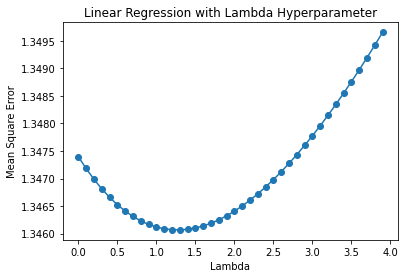

Optimal Lambda Hyperparamater is: 1.3
Cross Validation Error is: 1.3460667080501711
Mean Squared Error: 1.4361103474411636


In [154]:
# find best value for lambda
training_input, training_target = read_training_data()
accuracy = linear_regression_cross_validation(training_input, training_target)

# plot Mean Square error in relation to Lambda
x = np.arange(0, 4, 0.1).tolist()
plt.plot(x, accuracy, '-o')
plt.title('Linear Regression with Lambda Hyperparameter')
plt.ylabel('Mean Square Error')
plt.xlabel('Lambda')
plt.show()

# shape data to predict against full training set
optimal_lambda = accuracy.index(min(accuracy))*0.1
print("Optimal Lambda Hyperparamater is: " + str(optimal_lambda))
print("Cross Validation Error is: " + str(min(accuracy)))
training_target = np.array(list(itertools.chain.from_iterable(training_target)))
training_input = np.array(list(itertools.chain.from_iterable(training_input)))
training_input = np.c_[np.ones(training_target.size), training_input]
theta = linear_regression(training_input, training_target, optimal_lambda)

# predict test input and find squared error
test_input, test_target = read_test_data()
test_target = np.array(test_target)
test_input = np.array(test_input)
test_input = np.c_[np.ones(test_target.size), test_input]
predicted = test_input@theta
squared_error = np.square(predicted - test_target)
print("Mean Squared Error: " + str(np.mean(squared_error)))

    

# Question 3

Part a)
$$
\begin{align*}
L(w,b) &= \sum _{n=1}^{m}{r_n\left(y_n - wx_n + b\right)^2}\\
&= (y - v^T\overline{X})R(y - v^T\overline{X})^T \\
&= yRy^T - 2yR\overline{X}^Tv + v^T\overline{X}R\overline{X}^Tv \\
\textrm{where} \\
v &= \begin{bmatrix}
-b \\
w
\end{bmatrix} \\
y &= \begin{bmatrix}
y_1, y_2, ..., y_N
\end{bmatrix} \\
\overline{X} &= \begin{bmatrix}
1, 1, ..., 1 \\
x_1, x_2, ...,x_N 
\end{bmatrix} \\
\end{align*}
$$

Now assuming that the weights of $r_n$ are positive then the objective is a convex quadratic function of $w$ and $b$. The minimum then occurs at the point of zero gradient. 

$$
\begin{align*}
0 &= \nabla L(v) = -2\overline{X}Ry^T + 2\overline{X}R\overline{X}^Tv \\
\textrm{Solving for } v \\
v &= (\overline{X}R\overline{X}^T)^{-1} \overline{X}Ry^T \\
\end{align*}
$$

Part b)


Suppose $y_n = w^Tx_n - b + \epsilon _n$ where $\epsilon _n$ is a zero-mean Gaussian random variable with variance $\sigma _n^2$. Thus, the conditional density of $y_n$ given $x_n$ is a Gaussian with mean $w^Tx_n - b$ and variance $\sigma _i^2$. The negative log-likelihood is

$$
\begin{align*}
-l(w,b) &= -log Pr(y_1,...,y_N|x_1, ...,x_N) \\
&= -log \prod_{n=1}^{N}{Pr(y_n|x_n)} \\
&= - \sum _{n=1}^{N}{logPr(y_n|x_n)} \\
&= \sum _{n=1}^{N}{log\left(\sqrt{2\pi \sigma _n^2}\right)} + \sum _{n=1}^{N}{\frac{\left(y_n-w^Tx_n + b\right)^2}{2\sigma _n^2}} \\
\end{align*}
$$

First term is constant with respect to $w$ and $b$. So minimizing the negative log-likelihood is equivalent to minimizing only the second term, which is the same as our objective function with $r_n = \frac{1}{2\sigma _n^2}$. The variance of measurement $n$ in this model is thus inversely proportional to the weight $r_n : \sigma _n^2 \propto \frac{1}{r_n}$ 